In [1]:
%load_ext autoreload
%autoreload 2

## MNIST Image Reparametrization 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torch import optim
from torchvision.transforms.functional import gaussian_blur

from funcshape.transforms import Qmap2D
from funcshape.imageinterp import SingleChannelImageSurface
from funcshape.utils import torch_square_grid

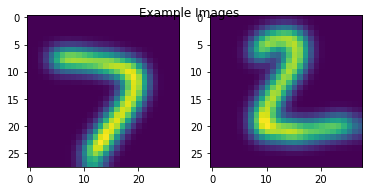

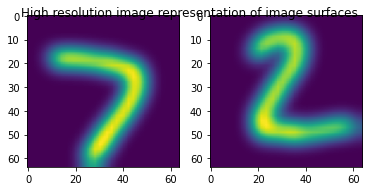

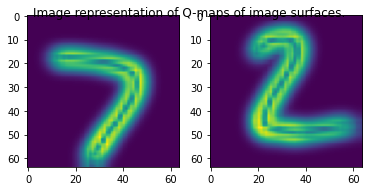

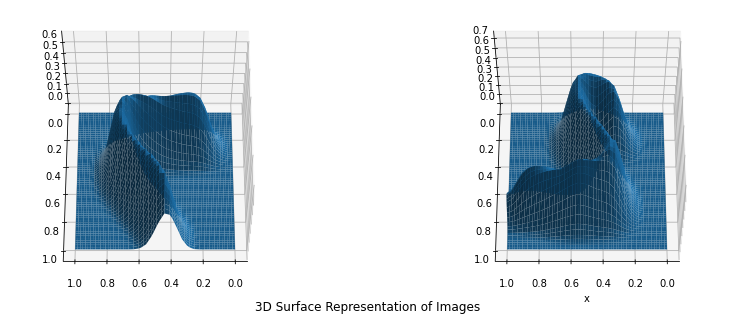

In [3]:
# Load Data
imgfile = "../data/t10k-images-idx3-ubyte"
imgdata = torch.tensor(idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels-idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [7, 7])
imgdata /= imgdata.max()

# Extract example images
img1 = imgdata[17]
img2 = imgdata[1]

# Show Images
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.suptitle("Example Images")
plt.subplots_adjust(top=1.25)
plt.show()

# Create surface representation of images
f = SingleChannelImageSurface(img1, centering=False, scaling=False, mode='bicubic')
g = SingleChannelImageSurface(img2, centering=False, scaling=False, mode='bicubic')

# Create sample data of Q-map representations of the images.
q = Qmap2D(f)
r = Qmap2D(g)


# Find example data of surface representations of the images.
k = 64
XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()
max_value = max(Zf[2].max(), Zg[2].max())
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

# Plot surfaces as images
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.suptitle("High resolution image representation of image surfaces")
plt.subplots_adjust(top=1.25)
plt.show()

# Plot the q-map representation as images.
fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.suptitle("Image representation of Q-maps of image surfaces.")
plt.subplots_adjust(top=1.25)
plt.show()

# 3D-plot of the surface representation of the images. 
fig = plt.figure(figsize=(12, 4))
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)

ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax.set_xlabel("x")
fig.suptitle("3D Surface Representation of Images")
plt.show(fig)

In [4]:
from funcshape.layers.sinefourier import SineFourierLayer
from funcshape.networks import SurfaceReparametrizer
from funcshape.loss import ImageComponentDistance, SurfaceDistance
from funcshape.reparametrize import reparametrize
from funcshape.logging import Logger
from funcshape.visual import plot_diffeomorphism_2d

[Iter     1] loss: 0.261030
[Iter     2] loss: 0.199310
[Iter     3] loss: 0.118980
[Iter     4] loss: 0.101224
[Iter     5] loss: 0.089251
[Iter     6] loss: 0.084120
[Iter     7] loss: 0.079731
[Iter     8] loss: 0.074268
[Iter     9] loss: 0.070620
[Iter    10] loss: 0.070596
[Iter    11] loss: 0.070565
[Iter    12] loss: 0.070373
[Iter    13] loss: 0.069788
[Iter    14] loss: 0.068714
[Iter    15] loss: 0.068221
[Iter    16] loss: 0.068194
[Iter    17] loss: 0.067847
[Iter    18] loss: 0.067820
[Iter    19] loss: 0.067507
[Iter    20] loss: 0.067325
[Iter    21] loss: 0.067262
[Iter    22] loss: 0.067249
[Iter    23] loss: 0.067234
[Iter    24] loss: 0.067234

Finished training in 14.92249s


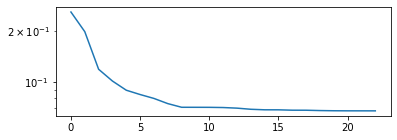

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineFourierLayer(4) for i in range(10)]
).to(device)

optimizer = optim.LBFGS(RN.parameters(), max_iter=200, line_search_fn="strong_wolfe")
loss_func = ImageComponentDistance(q, r, k=32, h=1e-4).to(device)
errors = reparametrize(RN, loss_func, optimizer, 200, Logger(1))
RN.detach()
RN.to("cpu"), loss_func.to("cpu");

plt.figure(figsize=(6, 2))
plt.semilogy(errors)
plt.show()

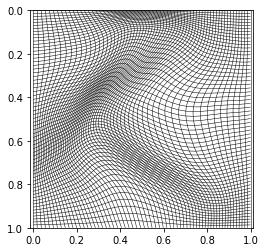

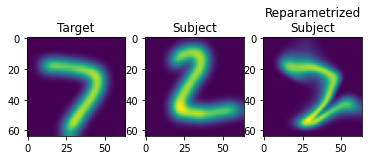

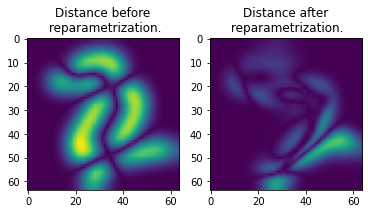

In [9]:
# =============== PLotting below +============

# Plot diffeomorphism as grid.
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_diffeomorphism_2d(RN, k=64, ax=ax, color="k", lw=0.5)
plt.axis("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.invert_yaxis()


# Get reparametrized surface data
Zg_after = g(RN(X)).view(k, k, 3).numpy()
max_value = max(Zg_after[..., 2].max(), max(Zg[2].max(), Zf[2].max()))

# Plot and compare images and errors.
fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax1.imshow(Zf[2],  vmin=0., vmax=max_value)
ax2.imshow(Zg[2], vmin=0., vmax=max_value)
ax3.imshow(Zg_after[..., 2], vmin=0., vmax=max_value)
ax1.set_title("Target")
ax2.set_title("Subject")
ax3.set_title("Reparametrized\nSubject")
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2)

ax1.imshow(np.abs(Zf[2] - Zg[2]), vmin=0., vmax=max_value)
ax3.imshow(np.abs(Zf[2] - Zg_after[..., 2]), vmin=0., vmax=max_value)
ax1.set_title("Distance before\n reparametrization.")
ax3.set_title("Distance after\n reparametrization.")
# plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-error.pdf")
plt.show()

## Image Interpolation 

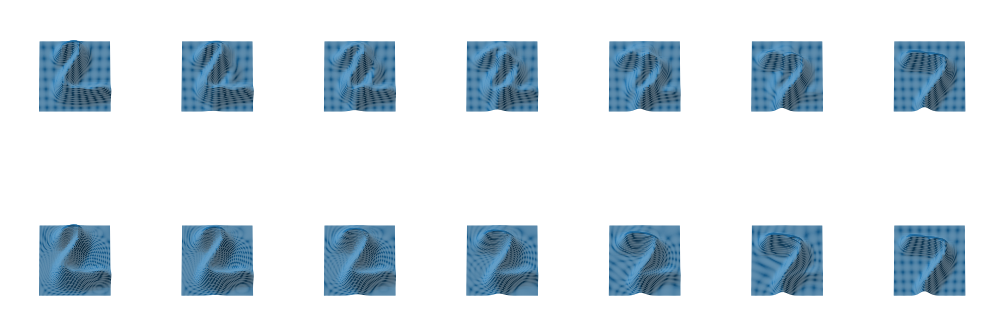

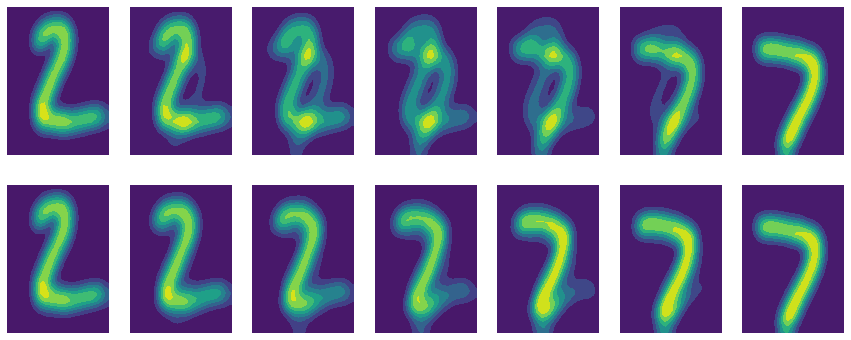

In [10]:
from funcshape.interpolation import linear_interpolate

numsteps = 7
with torch.no_grad():
    fig = plt.figure(figsize=(14, 6))
    for i, h in enumerate(linear_interpolate(g, f, numsteps)):
        ax = fig.add_subplot(2, numsteps, i+1, projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(linear_interpolate(lambda x: g(RN(x)), f, numsteps)):
        ax = fig.add_subplot(2, numsteps, i+(numsteps+1), projection="3d")
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.plot_surface(*Z, rstride=1, cstride=1)
        ax.view_init(80, -270)
        ax.invert_yaxis()
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    fig = plt.figure(figsize=(15, 6))
    for i, h in enumerate(linear_interpolate(g, f, numsteps)):
        ax = fig.add_subplot(2, numsteps, i+1)
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)# optimizer = optim.SGD(RN.parameters(), lr=1e-1, momentum=0.2)

        ax.invert_yaxis()
        ax.set_axis_off()

    for i, h in enumerate(linear_interpolate(lambda x: g(RN(x)), f, numsteps)):
        ax = fig.add_subplot(2, numsteps, i+(numsteps+1))
        Z = h(X).view(k, k, 3).permute(2, 0, 1).detach().numpy()
        ax.contourf(*Z)
        ax.invert_yaxis()
        ax.set_axis_off()
    plt.show()